In [3]:
# for dataset
import glob
import random
import os
import numpy as np
import torch
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms
# for models
import torch.nn as nn
import torch.nn.functional as F
import torch
from torchvision.models import vgg19
import math
# for GAN
import argparse
import os
import numpy as np
import math
import itertools
import sys
import torchvision.transforms as transforms
from torchvision.utils import save_image, make_grid
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch
from tqdm import tqdm


In [4]:
# Normalization parameters for pre-trained PyTorch models
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

In [5]:
class ImageDataset(Dataset):
    def __init__(self, root_files, hr_shape):
        hr_height, hr_width = hr_shape
        # Transforms for low resolution images and high resolution images
        self.lr_transform = transforms.Compose(
            [
                transforms.Resize((hr_height // 4, hr_height // 4), Image.BICUBIC),
                transforms.ToTensor(),
                transforms.Normalize(mean, std),
            ]
        )
        self.hr_transform = transforms.Compose(
            [
                transforms.Resize((hr_height, hr_height), Image.BICUBIC),
                transforms.ToTensor(),
                transforms.Normalize(mean, std),
            ]
        )

        self.files = root_files # Change to subset the data

    def __getitem__(self, index):
        img = Image.open(self.files[index % len(self.files)])
        img_lr = self.lr_transform(img)
        img_hr = self.hr_transform(img)

        return {"lr": img_lr, "hr": img_hr}

    def __len__(self):
        return len(self.files)

In [13]:
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        vgg19_model = vgg19(pretrained=True)
        self.feature_extractor = nn.Sequential(*list(vgg19_model.features.children())[:18])

    def forward(self, img):
        return self.feature_extractor(img)


class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_features, in_features, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(in_features, 0.8),
            nn.PReLU(),
            nn.Conv2d(in_features, in_features, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(in_features, 0.8),
        )

    def forward(self, x):
        return x + self.conv_block(x)


class GeneratorResNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, n_residual_blocks=16):
        super(GeneratorResNet, self).__init__()

        # First layer
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels, 64, kernel_size=9, stride=1, padding=4), nn.PReLU())

        # Residual blocks
        res_blocks = []
        for _ in range(n_residual_blocks):
            res_blocks.append(ResidualBlock(64))
        self.res_blocks = nn.Sequential(*res_blocks)

        # --------------------------------------------------------------------------
        # New convolutional layer (refinement layer) for a.
        # self.refine_conv = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        # --------------------------------------------------------------------------

        # Second conv layer post residual blocks
        self.conv2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1), nn.BatchNorm2d(64, 0.8))

        # Upsampling layers
        upsampling = []
        for out_features in range(2):
            upsampling += [
                # nn.Upsample(scale_factor=2),
                nn.Conv2d(64, 256, 3, 1, 1),
                nn.BatchNorm2d(256),
                nn.PixelShuffle(upscale_factor=2),
                nn.PReLU(),
            ]
        self.upsampling = nn.Sequential(*upsampling)

        # -----------------------------new for c.------------------------------
        # Additional PixelShuffle layer for higher resolution
        # self.extra_upsampling = nn.Sequential(
        #     nn.Conv2d(64, 256, kernel_size=3, stride=1, padding=1),
        #     nn.BatchNorm2d(256),
        #     nn.PixelShuffle(upscale_factor=2),
        #     nn.PReLU()
        # )
        # -----------------------------new for c.------------------------------

        # Final output layer
        self.conv3 = nn.Sequential(nn.Conv2d(64, out_channels, kernel_size=9, stride=1, padding=4), nn.Tanh())

    def forward(self, x):
        out1 = self.conv1(x)
        out = self.res_blocks(out1)
        # -----------------------------------
        # out = self.refine_conv(out) # new for a.
        # -----------------------------------
        out2 = self.conv2(out)
        out = torch.add(out1, out2)
        out = self.upsampling(out)
        # -----------------------------------
        # out = self.extra_upsampling(out) # new for c.
        # -----------------------------------
        out = self.conv3(out)
        return out


class Discriminator(nn.Module):
    def __init__(self, input_shape):
        super(Discriminator, self).__init__()

        self.input_shape = input_shape
        in_channels, in_height, in_width = self.input_shape
        patch_h, patch_w = int(in_height / 2 ** 4), int(in_width / 2 ** 4)
        self.output_shape = (1, patch_h, patch_w)

        def discriminator_block(in_filters, out_filters, first_block=False):
            layers = []
            layers.append(nn.Conv2d(in_filters, out_filters, kernel_size=3, stride=1, padding=1))
            if not first_block:
                layers.append(nn.BatchNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            layers.append(nn.Conv2d(out_filters, out_filters, kernel_size=3, stride=2, padding=1))
            layers.append(nn.BatchNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        layers = []
        in_filters = in_channels
        # comment from here for b.
        for i, out_filters in enumerate([64, 128, 256, 512]):
            layers.extend(discriminator_block(in_filters, out_filters, first_block=(i == 0)))
            in_filters = out_filters

        layers.append(nn.Conv2d(out_filters, 1, kernel_size=3, stride=1, padding=1))
        # comment to here for b.

        # -------------------------------------modified for b.--------------------------------------
        # # Add the first block
        # layers.extend(discriminator_block(in_filters, 64, first_block=True))

        # # Add a new convolutional layer
        # layers.append(nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1))  # New layer
        # layers.append(nn.LeakyReLU(0.2, inplace=True))  # Activation after the new layer

        # # Update remaining blocks to reflect the new input size
        # layers.extend(discriminator_block(128, 128))  # Match new input size
        # layers.extend(discriminator_block(128, 256))
        # layers.extend(discriminator_block(256, 512))

        # # Final classification layer
        # layers.append(nn.Conv2d(512, 1, kernel_size=3, stride=1, padding=1))
        # -------------------------------------modified for b.--------------------------------------

        self.model = nn.Sequential(*layers)

    def forward(self, img):
        return self.model(img)

In [14]:
# -------
#  Setup
# -------

os.makedirs("images", exist_ok=True)
os.makedirs("saved_models", exist_ok=True)

class Options:
    epoch = 0                           # epoch to start training from
    n_epochs = 10                      # number of epochs of training
    dataset_name = "img_align_celeba"   # name of the dataset
    batch_size = 4                      # size of the batches
    lr = 0.0002                         # adam: learning rate
    b1 = 0.5                            # adam: decay of first order momentum of gradient
    b2 = 0.999                          # adam: decay of first order momentum of gradient
    decay_epoch = 100                   # epoch from which to start lr decay
    n_cpu = 8                           # number of cpu threads to use during batch generation
    hr_height = 256                     # high res. image height
    hr_width = 256                      # high res. image width
    channels = 3                        # number of image channels
    sample_interval = 100               # interval between saving image samples
    checkpoint_interval = 10            # interval between model checkpoints
    sample_size = 100                    # size to sample the dataset (+200k full dataset)
opt = Options()

cuda = torch.cuda.is_available()
hr_shape = (opt.hr_height, opt.hr_width)
print(hr_shape)

# Initialize generator and discriminator
generator = GeneratorResNet()
discriminator = Discriminator(input_shape=(opt.channels, *hr_shape))
feature_extractor = FeatureExtractor()

# Set feature extractor to inference mode
feature_extractor.eval()

# Losses
criterion_GAN = torch.nn.MSELoss()
criterion_content = torch.nn.L1Loss()

if cuda:
    generator = generator.cuda()
    discriminator = discriminator.cuda()
    feature_extractor = feature_extractor.cuda()
    criterion_GAN = criterion_GAN.cuda()
    criterion_content = criterion_content.cuda()

if opt.epoch != 0:
    # Load pretrained models
    generator.load_state_dict(torch.load("saved_models/generator_%d.pth"))
    discriminator.load_state_dict(torch.load("saved_models/discriminator_%d.pth"))

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))

Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor

# Sample a subset of files
all_files = sorted(glob.glob("../data/%s/*.*" % opt.dataset_name))
sampled_files = random.sample(all_files, opt.sample_size)

dataloader = DataLoader(
    ImageDataset(sampled_files, hr_shape=hr_shape),
    batch_size=opt.batch_size,
    shuffle=True,
    # num_workers=opt.n_cpu, # Run with dedicated GPU
    num_workers=0,
)

(256, 256)


In [ ]:
# ----------
#  Training
# ----------

for epoch in range(opt.epoch, opt.n_epochs):
    
    # Added to track progress
    progress_bar = tqdm(enumerate(dataloader), total=len(dataloader), desc=f'Epoch {epoch + 1}/{opt.n_epochs}')

    # for i, imgs in enumerate(dataloader):
    for i, imgs in progress_bar:

        # Configure model input
        imgs_lr = Variable(imgs["lr"].type(Tensor))
        imgs_hr = Variable(imgs["hr"].type(Tensor))

        # Adversarial ground truths
        valid = Variable(Tensor(np.ones((imgs_lr.size(0), *discriminator.output_shape))), requires_grad=False)
        fake = Variable(Tensor(np.zeros((imgs_lr.size(0), *discriminator.output_shape))), requires_grad=False)

        # ------------------
        #  Train Generators
        # ------------------

        optimizer_G.zero_grad()

        # Generate a high resolution image from low resolution input
        gen_hr = generator(imgs_lr)

        # Adversarial loss
        loss_GAN = criterion_GAN(discriminator(gen_hr), valid)

        # Content loss
        gen_features = feature_extractor(gen_hr)
        real_features = feature_extractor(imgs_hr)
        loss_content = criterion_content(gen_features, real_features.detach())

        # Total loss
        loss_G = loss_content + 1e-3 * loss_GAN

        loss_G.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Loss of real and fake images
        loss_real = criterion_GAN(discriminator(imgs_hr), valid)
        loss_fake = criterion_GAN(discriminator(gen_hr.detach()), fake)

        # Total loss
        loss_D = (loss_real + loss_fake) / 2

        loss_D.backward()
        optimizer_D.step()

        # --------------
        #  Log Progress
        # --------------
        progress_bar.set_postfix(D_loss=loss_D.item(), G_loss=loss_G.item())
        # sys.stdout.write(
        #     "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
        #     % (epoch, opt.n_epochs, i, len(dataloader), loss_D.item(), loss_G.item())
        # )

        # batches_done = epoch * len(dataloader) + i
        # if batches_done % opt.sample_interval == 0:
        if epoch % opt.sample_interval == 0:
            # Save image grid with upsampled inputs and SRGAN outputs
            imgs_lr = nn.functional.interpolate(imgs_lr, scale_factor=4)
            gen_hr = make_grid(gen_hr, nrow=1, normalize=True)
            imgs_lr = make_grid(imgs_lr, nrow=1, normalize=True)
            img_grid = torch.cat((imgs_lr, gen_hr), -1)
            save_image(img_grid, "images/{epoch}.png", normalize=False)

    if epoch == opt.n_epochs -1:
    # if opt.checkpoint_interval != -1 and epoch % opt.checkpoint_interval == 0:
        # Save model checkpoints
        torch.save(generator.state_dict(), "saved_models/generator_%d.pth" % epoch)
        torch.save(discriminator.state_dict(), "saved_models/discriminator_%d.pth" % epoch)

Epoch 1/10:   0%|          | 0/25 [00:00<?, ?it/s]

In [15]:
# Load the trained generator model
generator = GeneratorResNet()  # Make sure the model architecture matches
generator.load_state_dict(torch.load("saved_models/baseline_generator_9.pth"))
generator.eval()

# Preprocessing function (resize, normalize)
def preprocess_image(image_path, lr_height, lr_width):
    img = Image.open(image_path).convert("RGB")  # Open and convert to RGB
    transform = transforms.Compose([
        transforms.Resize((lr_height, lr_width), Image.BICUBIC),  # Downscale to match training size
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ])
    img = transform(img).unsqueeze(0)  # Add batch dimension
    return img

/var/folders/dj/x6hf7q8d3rncgk_107zpxr_00000gn/T/ipykernel_65415/2437025666.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load("saved_m

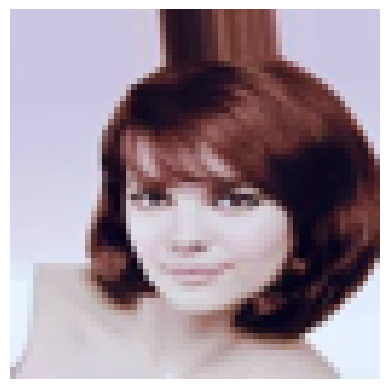

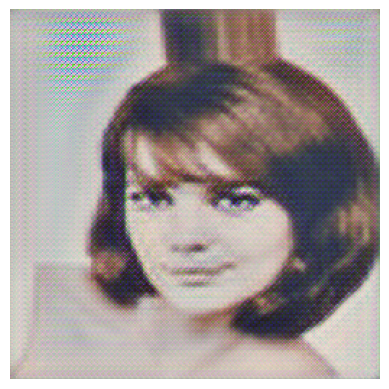

In [17]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils
# Load and preprocess the image
image_path = "q2_test_img/108423.jpg"
img_lr = preprocess_image(image_path, opt.hr_height // 4, opt.hr_width // 4)
img_lr = img_lr.cuda() if torch.cuda.is_available() else img_lr  # Move to GPU if available

plt.figure()
plt.imshow(vutils.make_grid(img_lr.cpu(), normalize=True).permute(1, 2, 0))
plt.axis('off')

# Generate the high-resolution image
with torch.no_grad():
    generated_hr = generator(img_lr)

# Denormalize the image (reverse the normalization step)
def denormalize_image(tensor, mean, std):
    for c in range(3):
        tensor[0, c, :, :] = tensor[0, c, :, :] * std[c] + mean[c]
    return tensor

generated_hr = denormalize_image(generated_hr, mean, std)

# Display the result
plt.figure(2)
plt.imshow(vutils.make_grid(generated_hr.cpu(), normalize=True).permute(1, 2, 0))
plt.axis('off')
plt.show()